<h1 style="background-color:powderblue;">Seoul Bike Rental Prediction - AI-Pro - ITI </h1>


##### The Seoul Metropolitan Government launched a public bike-sharing service in 2015 called Seoul Bikes (“Ddareungi” in Korean). It was designed to be a self-operating rental service that could be used conveniently by anyone. Today in Seoul, there are over 150 rental stations centered in five areas of the city (Yeouido, Sangam, Sinchon, the 4 Great Gates area, and Seongsu). Currently there are 2,000 Seoul Bikes available to users, with plans to expand the project in the coming years. Seoul Bikes are a great way to travel distances that are a bit too far to walk, but a bit to close to bother with public transportation or a taxi. The bikes are eco-friendly, user friendly, and low-cost. Take a bike out for a spin and see a new side of Seoul.

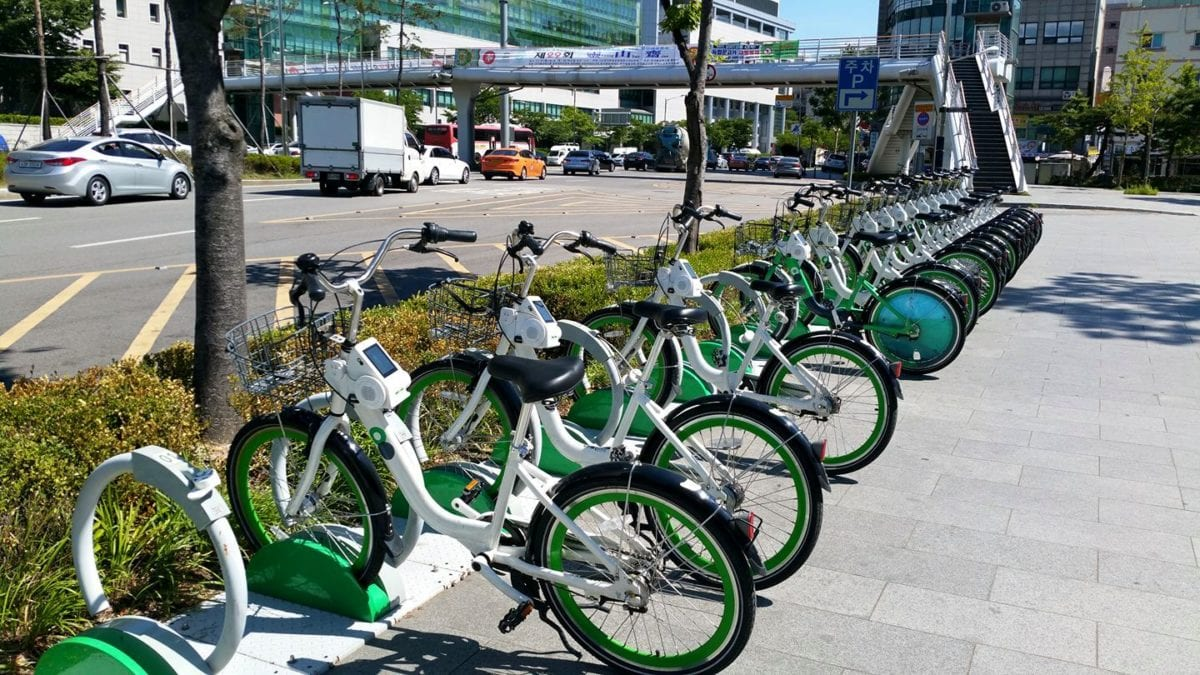

## Data fields

- `ID` - an ID for this instance
- `Date` - year-month-day
- `Hour` - Hour of he day
- `Temperature` - Temperature in Celsius
- `Humidity` - %
- `Windspeed` - m/s
- `Visibility` - 10m
- `Dew point temperature` - Celsius
- `Solar radiation` - MJ/m2
- `Rainfall` - mm
- `Snowfall` - cm
- `Seasons` - Winter, Spring, Summer, Autumn
- `Holiday` - Holiday/No holiday
- `Functional Day` - NoFunc(Non Functional Hours), Fun(Functional hours)
- `y` - Rented Bike count (Target), Count of bikes rented at each hour

# Team Members

In [1]:
##################################################################################################################
#  Team Members :
#                 1-Abdullah Abdelhakeem
#                 2-Mohamed Sebaie
#                 3-Mohamed Mostafa
#                 4-Osama Ahmed
#                 5-Mahmoud Osama 
#
#  Version: v1.1.0 (Submitted)
#  Description: Seoul Bike Rental Prediction - AI-Pro - ITI
#  
#################################################################################################################

# Import Required Libraries

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
#!pip install catboost
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
%matplotlib inline
# ignore the warnings
import warnings
warnings.filterwarnings("ignore")
sns.set(rc={'figure.figsize': [7, 7]}, font_scale=1.2)
%config Completer.use_jedi=False
pd.set_option("display.max_columns", None)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/seoul-bike-rental-ai-pro-iti/sample_submission.csv
/kaggle/input/seoul-bike-rental-ai-pro-iti/train.csv
/kaggle/input/seoul-bike-rental-ai-pro-iti/test.csv


# Read Train and Test Data

In [3]:
dataset_path = 'dataset/'

dfTrainO = pd.read_csv(os.path.join(dataset_path, 'train.csv'))
dfTestO = pd.read_csv(os.path.join(dataset_path, 'test.csv'))
print("The shape of the dataset is {}.\n\n".format(dfTrainO.shape))
print("The shape of the dataset is {}.\n\n".format(dfTestO.shape))
dfTrainO.head()

The shape of the dataset is (5760, 15).


The shape of the dataset is (3000, 14).




,ID,Date,y,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


__________________________________________________

# Preprocessing

In [4]:
dictHoliday={"No Holiday":0,"Holiday":1}
dictFunction={"Yes":1,"No":0}
dictYears={2017:0,2018:1}

In [5]:
def Preprocessing(df):
    df["Date"]            = pd.to_datetime(df["Date"], format='%d/%m/%Y')
    df["Year"]            = df['Date'].dt.year
    df["Month"]           = df['Date'].dt.month
    df["Day"]             = df["Date"].dt.day
    df["DayName"]         = df['Date'].dt.day_name()
    df["DayNumber"]       = df["Date"].dt.dayofweek
    df["WorkingDay"]      = df['Date'].dt.weekday.apply(lambda x: 0 if (x == 5) | (x == 6) else 1)
    df['WorkingDay']      = np.where((df['WorkingDay']==1 )& (df['Holiday']=="Holiday"), 0, df['WorkingDay'])
    df["Holiday"]         = df["Holiday"].map(dictHoliday)
    df["Functioning Day"] = df["Functioning Day"].map(dictFunction)
    df["Year"]            = df["Year"].map(dictYears)
    
    df.rename(columns={"Temperature(�C)": 'Temperature',"Dew point temperature(�C)": 'Dew_Point',
                             'Humidity(%)':'Humidity','Wind speed (m/s)':'Wind_Speed','Visibility (10m)':'Visibility',
                             'Solar Radiation (MJ/m2)':'Solar_Radiation','Rainfall(mm)':'Rainfall',
                             'Snowfall (cm)':'Snowfall','Functioning Day':'Functioning_Day'},inplace=True)
    df['Temperature']=np.floor(df['Temperature']).astype(int)
    
    def extract_period_of_day1(hour):
        if hour in range(12):
            return 'Morning'
        elif hour in range(12, 18):
            return 'Afternoon'
        elif hour in range(18, 22):
            return 'Evening'
        else:
            return 'Night'
    def extract_period_of_day2(hour):
        if hour in range(6,19):
            return 1
        elif hour in range(19,24):
            return 0
        else:
            return 0
    def is_rush_hour(hour):
        return 1 if hour in [8,16, 17, 18, 19, 20, 21, 22] else 0
    def encode(data, col, max_val):
        data[col + '_Sin'] = np.sin(2 * np.pi * data[col]/max_val)
        data[col + '_Cos'] = np.cos(2 * np.pi * data[col]/max_val)
        return data

    df['Day_Period']   = df['Hour'].apply(extract_period_of_day1)
    df['Rush_Hour']    = df['Hour'].apply(is_rush_hour)
    df = encode(df,'Hour',23)
    df = encode(df,'DayNumber',6)
    df = encode(df,'Month',12)
    return df

### Train

In [6]:
dfTrainNEW=Preprocessing(dfTrainO)
dfTrainNEW.head()

,ID,Date,y,Hour,Temperature,Humidity,Wind_Speed,Visibility,Dew_Point,Solar_Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning_Day,Year,Month,Day,DayName,DayNumber,WorkingDay,Day_Period,Rush_Hour,Hour_Sin,Hour_Cos,DayNumber_Sin,DayNumber_Cos,Month_Sin,Month_Cos
0,0,2017-12-01,254,0,-6,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,0,1,0,12,1,Friday,4,1,Morning,0,0.000000,1.000000,-0.866025,-0.5,-2.449294e-16,1.0
1,1,2017-12-01,204,1,-6,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,0,1,0,12,1,Friday,4,1,Morning,0,0.269797,0.962917,-0.866025,-0.5,-2.449294e-16,1.0
2,2,2017-12-01,173,2,-6,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,0,1,0,12,1,Friday,4,1,Morning,0,0.519584,0.854419,-0.866025,-0.5,-2.449294e-16,1.0
3,3,2017-12-01,107,3,-7,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,0,1,0,12,1,Friday,4,1,Morning,0,0.730836,0.682553,-0.866025,-0.5,-2.449294e-16,1.0
4,4,2017-12-01,78,4,-6,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,0,1,0,12,1,Friday,4,1,Morning,0,0.887885,0.460065,-0.866025,-0.5,-2.449294e-16,1.0


### Test

In [7]:
dfTestNEW=Preprocessing(dfTestO)
dfTestNEW.head()

,ID,Date,Hour,Temperature,Humidity,Wind_Speed,Visibility,Dew_Point,Solar_Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning_Day,Year,Month,Day,DayName,DayNumber,WorkingDay,Day_Period,Rush_Hour,Hour_Sin,Hour_Cos,DayNumber_Sin,DayNumber_Cos,Month_Sin,Month_Cos
0,5760,2017-12-21,0,-2,90,2.0,259,-2.7,0.0,0.0,2.2,Winter,0,1,0,12,21,Thursday,3,1,Morning,0,0.000000,1.000000,1.224647e-16,-1.0,-2.449294e-16,1.0
1,5761,2017-12-21,1,-2,90,1.6,263,-3.2,0.0,0.0,2.2,Winter,0,1,0,12,21,Thursday,3,1,Morning,0,0.269797,0.962917,1.224647e-16,-1.0,-2.449294e-16,1.0
2,5762,2017-12-21,2,-3,88,1.4,348,-3.9,0.0,0.0,2.2,Winter,0,1,0,12,21,Thursday,3,1,Morning,0,0.519584,0.854419,1.224647e-16,-1.0,-2.449294e-16,1.0
3,5763,2017-12-21,3,-3,89,1.3,288,-4.4,0.0,0.0,2.2,Winter,0,1,0,12,21,Thursday,3,1,Morning,0,0.730836,0.682553,1.224647e-16,-1.0,-2.449294e-16,1.0
4,5764,2017-12-21,4,-4,91,1.2,241,-4.8,0.0,0.0,2.2,Winter,0,1,0,12,21,Thursday,3,1,Morning,0,0.887885,0.460065,1.224647e-16,-1.0,-2.449294e-16,1.0


# Value Counts and Uniques Equations

In [8]:
def ValueCounts(df):
    for c in df.columns:
        print(c+"\n"+"-----------------"+"\n")
        print(df[c].value_counts().to_frame())
        print("\n"+"******************"+"\n")
        
def UniqueValues(df,l):
    for c in l:
        print(c+"\n"+"-----------------"+"\n")
        print(df[c].unique())
        print("\n"+"******************"+"\n")

In [9]:
ValueCounts(dfTrainNEW)

ID
-----------------

      ID
0      1
1290   1
3335   1
1286   1
5380   1
...   ..
637    1
2684   1
4731   1
633    1
2047   1

[5760 rows x 1 columns]

******************

Date
-----------------

            Date
2017-12-14    24
2018-11-17    24
2018-05-15    24
2017-12-08    24
2018-11-11    24
...          ...
2018-03-09    24
2017-12-20    24
2018-09-05    24
2018-06-18    24
2018-03-03    24

[240 rows x 1 columns]

******************

y
-----------------

        y
0     247
223    16
165    14
190    13
71     13
...   ...
1806    1
1818    1
1822    1
1826    1
801     1

[1890 rows x 1 columns]

******************

Hour
-----------------

    Hour
0    240
4    240
19   240
15   240
11   240
7    240
3    240
22   240
18   240
14   240
10   240
6    240
2    240
21   240
17   240
13   240
9    240
5    240
1    240
20   240
16   240
12   240
8    240
23   240

******************

Temperature
-----------------

     Temperature
 20          207
 19          199
 18         

In [10]:
ValueCounts(dfTestNEW)

ID
-----------------

      ID
8192   1
8695   1
6638   1
8687   1
6640   1
...   ..
7581   1
7583   1
7585   1
7587   1
6143   1

[3000 rows x 1 columns]

******************

Date
-----------------

            Date
2018-08-30    24
2018-05-29    24
2018-11-23    24
2018-08-25    24
2018-05-27    24
...          ...
2017-12-30    24
2018-11-22    24
2018-08-24    24
2018-05-26    24
2018-05-21    24

[125 rows x 1 columns]

******************

Hour
-----------------

    Hour
0    125
2    125
21   125
19   125
17   125
15   125
13   125
11   125
9    125
7    125
5    125
3    125
1    125
22   125
20   125
18   125
16   125
14   125
12   125
10   125
8    125
6    125
4    125
23   125

******************

Temperature
-----------------

     Temperature
 24          117
 5           113
 23          109
 20          108
 22          101
 2            92
 6            90
 21           88
 19           85
 16           84
 12           82
 9            81
 1            80
 17         

In [11]:
UniqueValues(dfTrainNEW,dfTrainNEW.columns)

ID
-----------------

[   0    1    2 ... 5757 5758 5759]

******************

Date
-----------------

['2017-12-01T00:00:00.000000000' '2017-12-02T00:00:00.000000000'
 '2017-12-03T00:00:00.000000000' '2017-12-04T00:00:00.000000000'
 '2017-12-05T00:00:00.000000000' '2017-12-06T00:00:00.000000000'
 '2017-12-07T00:00:00.000000000' '2017-12-08T00:00:00.000000000'
 '2017-12-09T00:00:00.000000000' '2017-12-10T00:00:00.000000000'
 '2017-12-11T00:00:00.000000000' '2017-12-12T00:00:00.000000000'
 '2017-12-13T00:00:00.000000000' '2017-12-14T00:00:00.000000000'
 '2017-12-15T00:00:00.000000000' '2017-12-16T00:00:00.000000000'
 '2017-12-17T00:00:00.000000000' '2017-12-18T00:00:00.000000000'
 '2017-12-19T00:00:00.000000000' '2017-12-20T00:00:00.000000000'
 '2018-01-01T00:00:00.000000000' '2018-01-02T00:00:00.000000000'
 '2018-01-03T00:00:00.000000000' '2018-01-04T00:00:00.000000000'
 '2018-01-05T00:00:00.000000000' '2018-01-06T00:00:00.000000000'
 '2018-01-07T00:00:00.000000000' '2018-01-08T00:00:0

In [12]:
UniqueValues(dfTestNEW,dfTestNEW.columns)

ID
-----------------

[5760 5761 5762 ... 8757 8758 8759]

******************

Date
-----------------

['2017-12-21T00:00:00.000000000' '2017-12-22T00:00:00.000000000'
 '2017-12-23T00:00:00.000000000' '2017-12-24T00:00:00.000000000'
 '2017-12-25T00:00:00.000000000' '2017-12-26T00:00:00.000000000'
 '2017-12-27T00:00:00.000000000' '2017-12-28T00:00:00.000000000'
 '2017-12-29T00:00:00.000000000' '2017-12-30T00:00:00.000000000'
 '2017-12-31T00:00:00.000000000' '2018-01-21T00:00:00.000000000'
 '2018-01-22T00:00:00.000000000' '2018-01-23T00:00:00.000000000'
 '2018-01-24T00:00:00.000000000' '2018-01-25T00:00:00.000000000'
 '2018-01-26T00:00:00.000000000' '2018-01-27T00:00:00.000000000'
 '2018-01-28T00:00:00.000000000' '2018-01-29T00:00:00.000000000'
 '2018-01-30T00:00:00.000000000' '2018-01-31T00:00:00.000000000'
 '2018-02-21T00:00:00.000000000' '2018-02-22T00:00:00.000000000'
 '2018-02-23T00:00:00.000000000' '2018-02-24T00:00:00.000000000'
 '2018-02-25T00:00:00.000000000' '2018-02-26T00:00:0

In [13]:
dfTrainNEW.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,5760.0,2.879500e+03,1662.913107,0.000000,1439.750000,2.879500e+03,4319.250000,5759.000000
y,5760.0,7.034839e+02,655.249491,0.000000,188.000000,4.855000e+02,1066.000000,3556.000000
Hour,5760.0,1.150000e+01,6.922788,0.000000,5.750000,1.150000e+01,17.250000,23.000000
Temperature,5760.0,1.234983e+01,11.906842,-16.000000,3.000000,1.300000e+01,22.000000,39.000000
Humidity,5760.0,5.836181e+01,19.840167,0.000000,43.000000,5.700000e+01,73.000000,98.000000
Wind_Speed,5760.0,1.723333e+00,1.047898,0.000000,0.900000,1.500000e+00,2.300000,7.400000
Visibility,5760.0,1.473711e+03,585.879880,27.000000,1025.750000,1.732000e+03,2000.000000,2000.000000
Dew_Point,5760.0,4.058264e+00,13.003582,-26.900000,-5.400000,5.200000e+00,14.700000,27.200000
Solar_Radiation,5760.0,5.723247e-01,0.869943,0.000000,0.000000,1.000000e-02,0.940000,3.520000
Rainfall,5760.0,1.351215e-01,1.075320,0.000000,0.000000,0.000000e+00,0.000000,35.000000


In [14]:
dfTestNEW.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,3000.0,7.259500e+03,866.169729,5760.000000,6509.750000,7.259500e+03,8009.250000,8759.000000
Hour,3000.0,1.150000e+01,6.923341,0.000000,5.750000,1.150000e+01,17.250000,23.000000
Temperature,3000.0,1.258233e+01,12.036951,-18.000000,3.000000,1.350000e+01,22.000000,38.000000
Humidity,3000.0,5.796600e+01,21.330288,0.000000,40.000000,5.800000e+01,76.000000,98.000000
Wind_Speed,3000.0,1.727933e+00,1.013826,0.000000,0.900000,1.500000e+00,2.400000,6.900000
Visibility,3000.0,1.366005e+03,643.374688,33.000000,779.000000,1.591500e+03,2000.000000,2000.000000
Dew_Point,3000.0,4.103667e+00,13.170840,-30.600000,-3.900000,4.900000e+00,15.600000,26.800000
Solar_Radiation,3000.0,5.629400e-01,0.866555,0.000000,0.000000,1.000000e-02,0.910000,3.520000
Rainfall,3000.0,1.747333e-01,1.223086,0.000000,0.000000,0.000000e+00,0.000000,29.500000
Snowfall,3000.0,1.303000e-01,0.592634,0.000000,0.000000,0.000000e+00,0.000000,8.800000


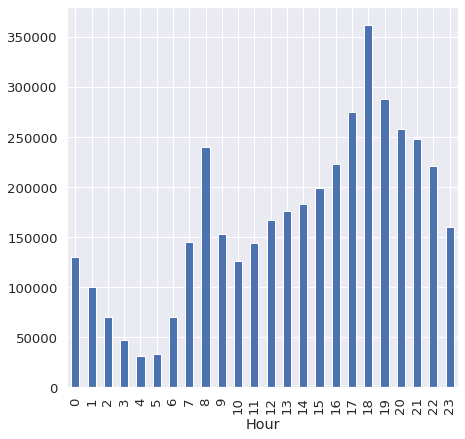

In [15]:
dfTrainNEW.groupby('Hour')['y'].sum().plot(kind='bar');

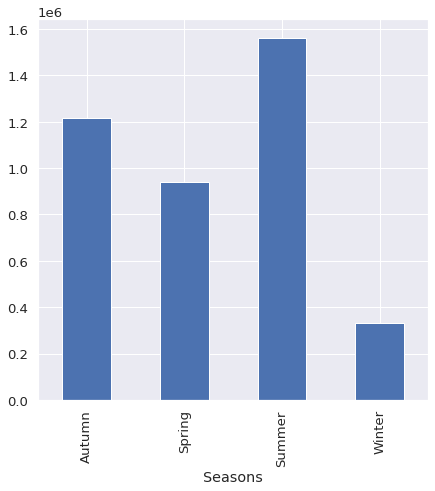

In [16]:
dfTrainNEW.groupby('Seasons')['y'].sum().plot(kind='bar');

_________________________________________________

# Check for skewness

## Train

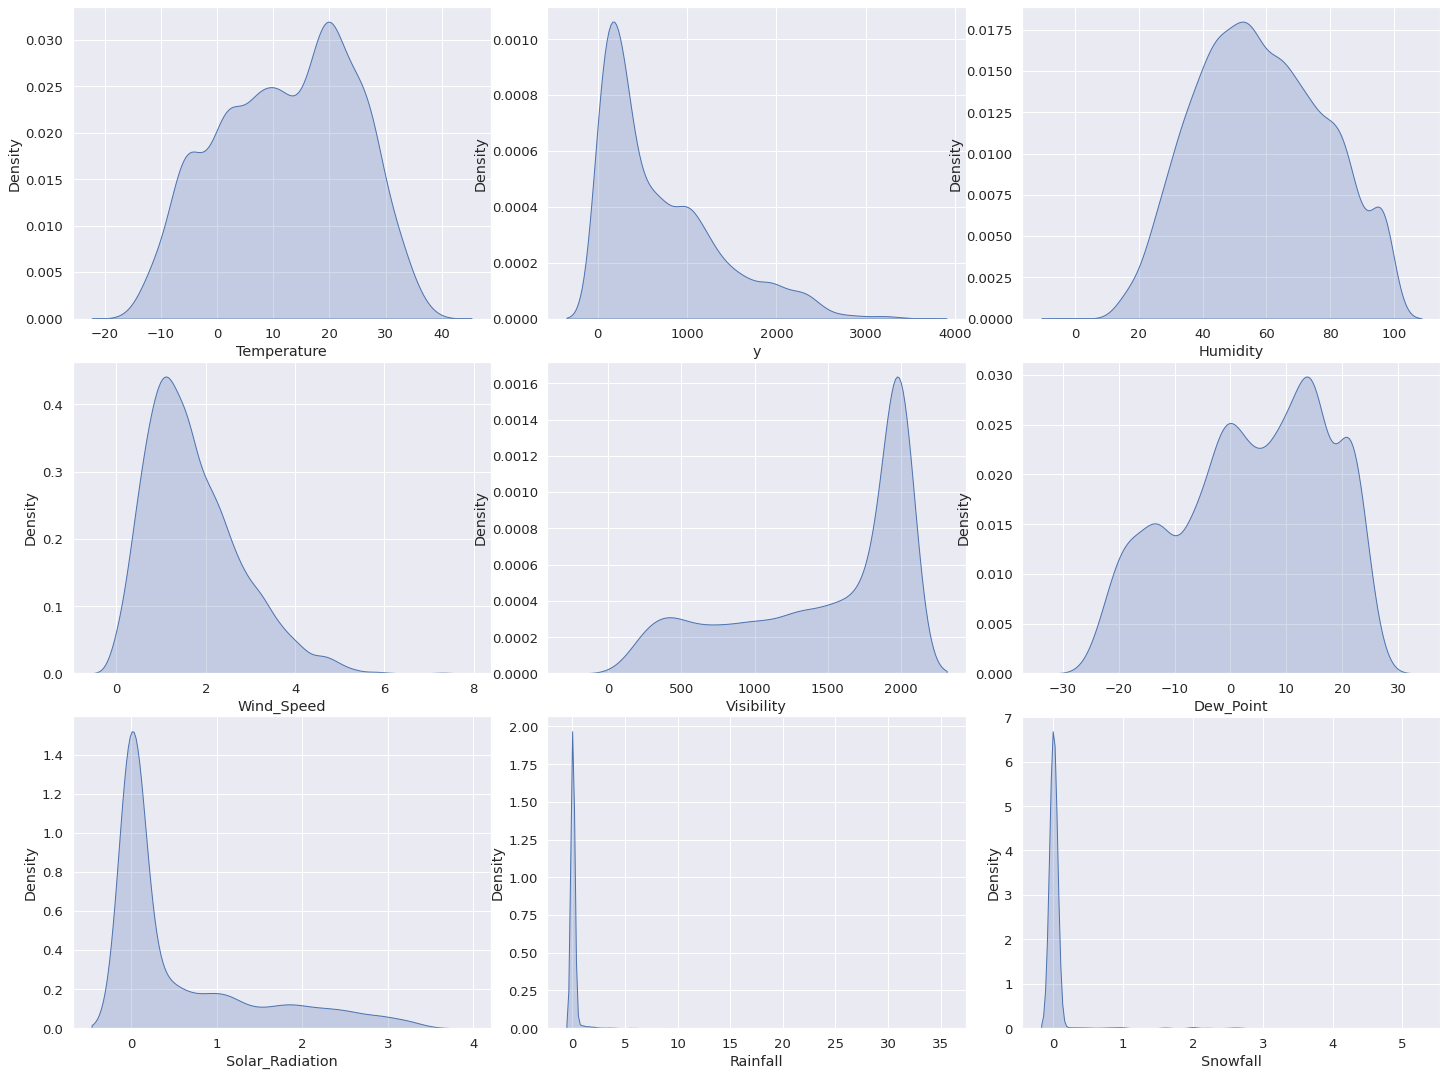

In [17]:
figure, axes = plt.subplots(nrows=3, ncols=3)
figure.set_size_inches(20,15)
figure.tight_layout()
sns.kdeplot(dfTrainNEW['Temperature']    ,shade=True, ax=axes[0][0]);
sns.kdeplot(dfTrainNEW['y']              ,shade=True, ax=axes[0][1]);
sns.kdeplot(dfTrainNEW['Humidity']       ,shade=True, ax=axes[0][2]);
sns.kdeplot(dfTrainNEW['Wind_Speed']     ,shade=True, ax=axes[1][0]);
sns.kdeplot(dfTrainNEW['Visibility']     ,shade=True, ax=axes[1][1]);
sns.kdeplot(dfTrainNEW['Dew_Point']      ,shade=True, ax=axes[1][2]);
sns.kdeplot(dfTrainNEW['Solar_Radiation'],shade=True, ax=axes[2][0]);
sns.kdeplot(dfTrainNEW['Rainfall']       ,shade=True, ax=axes[2][1]);
sns.kdeplot(dfTrainNEW['Snowfall']       ,shade=True, ax=axes[2][2]);

## Features to Check: `y`, `Wind_Speed`,`Visibility`,`Solar_Radiation`,`Rainfall`,`Snowfall`

In [18]:
def SkewnessCheck(df,feature):
    df['log'+feature]   =df[feature].apply(np.log1p)
    df['sqrt'+feature]  =df[feature].apply(np.sqrt)
    df['squar'+feature] =np.power(df[feature],2)
    figure, axes = plt.subplots(nrows=1, ncols=4)
    figure.set_size_inches(20,10)
    sns.kdeplot(df['y']              ,shade=True, ax=axes[0]);
    sns.kdeplot(df['log'+feature]    ,shade=True, ax=axes[1]);
    sns.kdeplot(df['sqrt'+feature]   ,shade=True, ax=axes[2]);
    sns.kdeplot(df['squar'+feature]  ,shade=True, ax=axes[3]);

## `y`

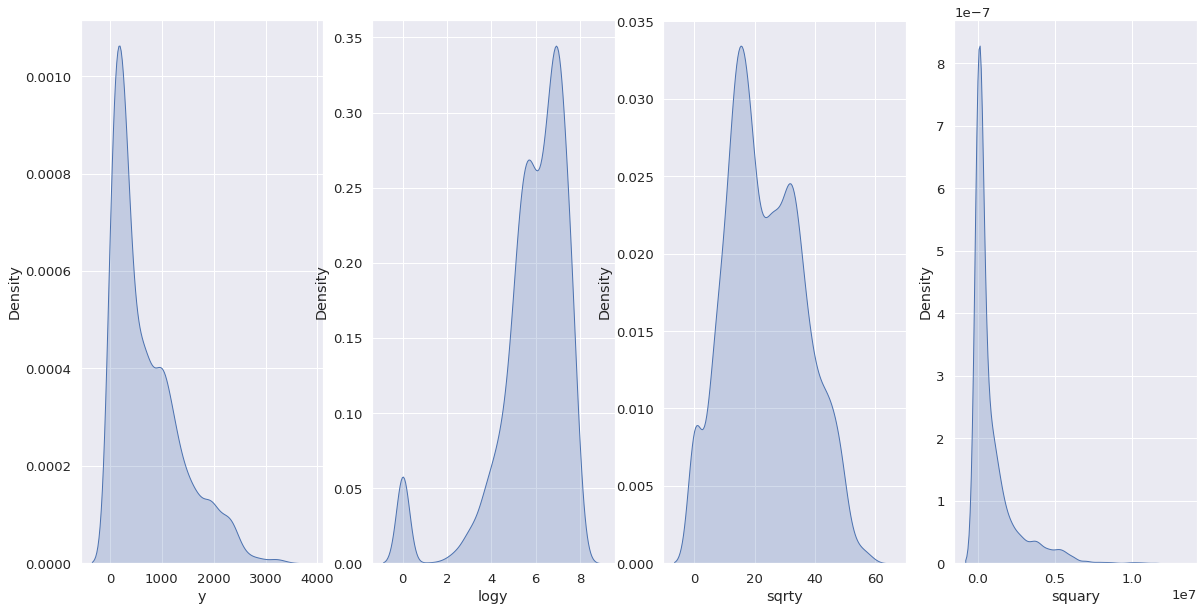

In [19]:
SkewnessCheck(dfTrainNEW,'y')

## `Wind_Speed`

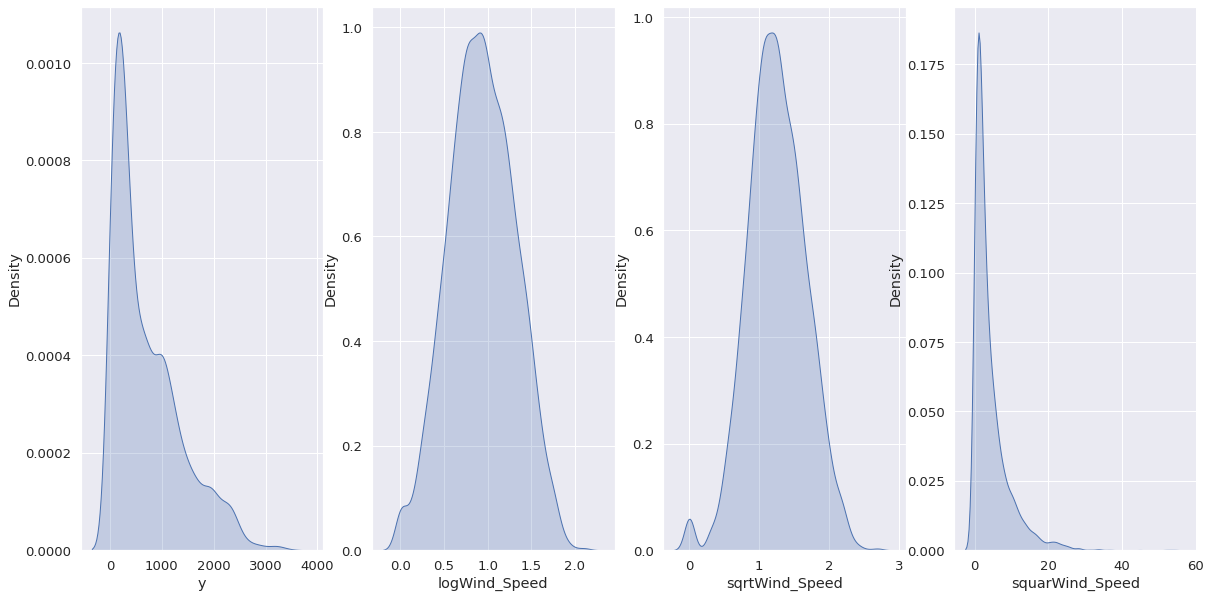

In [20]:
SkewnessCheck(dfTrainNEW,'Wind_Speed')

## `Visibility`

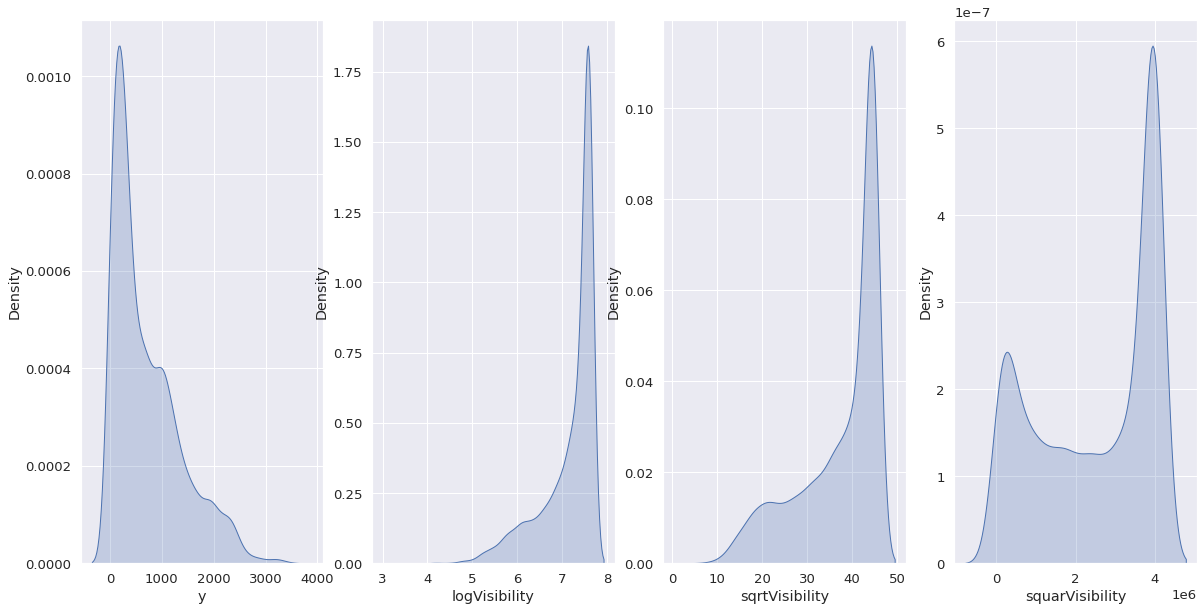

In [21]:
SkewnessCheck(dfTrainNEW,'Visibility')

## `Solar_Radiation`

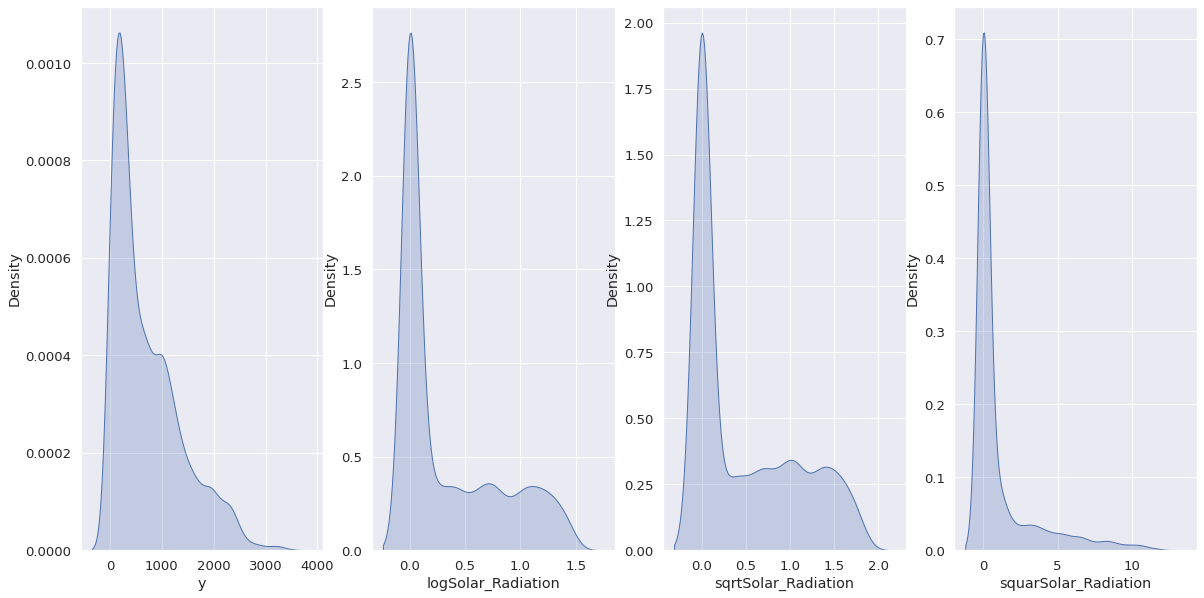

In [22]:
SkewnessCheck(dfTrainNEW,'Solar_Radiation')

## `Rainfall`

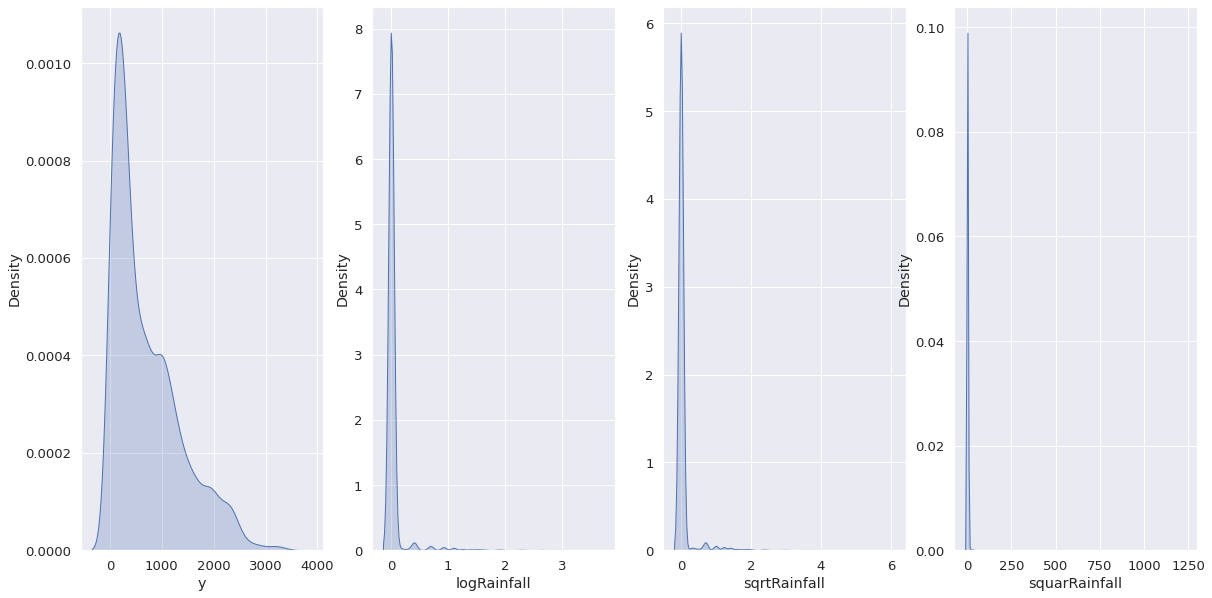

In [23]:
SkewnessCheck(dfTrainNEW,'Rainfall')

## `Snowfall`

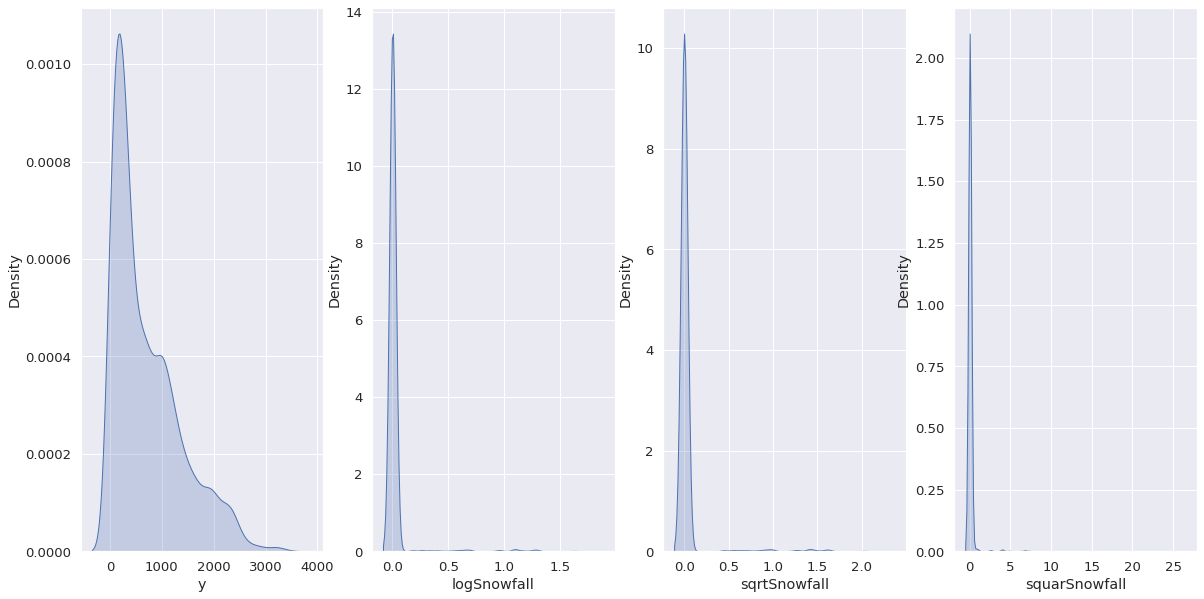

In [24]:
SkewnessCheck(dfTrainNEW,'Snowfall')

#### `SquareRoot` Y        ------> Best
#### `Log` WindSpeed       ------> Best
#### `Square` Visibility   ------> Best
### `SolarRadiation`?? Original or SquareRoot

## Do The Same To Test Data

In [25]:
dfTestNEW['logWind_Speed']         =dfTestNEW['Wind_Speed'].apply(np.log1p)
dfTestNEW['sqrtWind_Speed']        =dfTestNEW['Wind_Speed'].apply(np.sqrt)
dfTestNEW['squarWind_Speed']       =np.power(dfTestNEW['Wind_Speed'],2)
dfTestNEW['logVisibility']         =dfTestNEW['Visibility'].apply(np.log1p)
dfTestNEW['sqrtVisibility']        =dfTestNEW['Visibility'].apply(np.sqrt)
dfTestNEW['squarVisibility']       =np.power(dfTestNEW['Visibility'],2)
dfTestNEW['logSolar_Radiation']    =dfTestNEW['Solar_Radiation'].apply(np.log1p)
dfTestNEW['sqrtSolar_Radiation']   =dfTestNEW['Solar_Radiation'].apply(np.sqrt)
dfTestNEW['squarSolar_Radiation']  =np.power(dfTestNEW['Solar_Radiation'],2)
dfTestNEW['logRainfall']           =dfTestNEW['Rainfall'].apply(np.log1p)
dfTestNEW['sqrtRainfall']          =dfTestNEW['Rainfall'].apply(np.sqrt)
dfTestNEW['squarRainfall']         =np.power(dfTestNEW['Rainfall'],2)
dfTestNEW['logSnowfall']           =dfTestNEW['Snowfall'].apply(np.log1p)
dfTestNEW['sqrtSnowfall']          =dfTestNEW['Snowfall'].apply(np.sqrt)
dfTestNEW['squarSnowfall']         =np.power(dfTestNEW['Snowfall'],2)

## Drop the Columns we Don't Need

In [26]:
dfTrainNEW.columns

Index(['ID', 'Date', 'y', 'Hour', 'Temperature', 'Humidity', 'Wind_Speed',
       'Visibility', 'Dew_Point', 'Solar_Radiation', 'Rainfall', 'Snowfall',
       'Seasons', 'Holiday', 'Functioning_Day', 'Year', 'Month', 'Day',
       'DayName', 'DayNumber', 'WorkingDay', 'Day_Period', 'Rush_Hour',
       'Hour_Sin', 'Hour_Cos', 'DayNumber_Sin', 'DayNumber_Cos', 'Month_Sin',
       'Month_Cos', 'logy', 'sqrty', 'squary', 'logWind_Speed',
       'sqrtWind_Speed', 'squarWind_Speed', 'logVisibility', 'sqrtVisibility',
       'squarVisibility', 'logSolar_Radiation', 'sqrtSolar_Radiation',
       'squarSolar_Radiation', 'logRainfall', 'sqrtRainfall', 'squarRainfall',
       'logSnowfall', 'sqrtSnowfall', 'squarSnowfall'],
      dtype='object')

In [27]:
dfTrainNEW.drop(columns=['logy','squary','sqrtWind_Speed','squarWind_Speed', 'sqrtVisibility', 'logVisibility',
                       'logSolar_Radiation','squarSolar_Radiation','logRainfall',
                       'sqrtRainfall', 'squarRainfall', 'logSnowfall', 'sqrtSnowfall','squarSnowfall'],inplace=True)

In [28]:
dfTrainNEW.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5760 entries, 0 to 5759
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   5760 non-null   int64         
 1   Date                 5760 non-null   datetime64[ns]
 2   y                    5760 non-null   int64         
 3   Hour                 5760 non-null   int64         
 4   Temperature          5760 non-null   int64         
 5   Humidity             5760 non-null   int64         
 6   Wind_Speed           5760 non-null   float64       
 7   Visibility           5760 non-null   int64         
 8   Dew_Point            5760 non-null   float64       
 9   Solar_Radiation      5760 non-null   float64       
 10  Rainfall             5760 non-null   float64       
 11  Snowfall             5760 non-null   float64       
 12  Seasons              5760 non-null   object        
 13  Holiday              5760 non-nul

In [29]:
dfTestNEW.drop(columns=['sqrtWind_Speed', 'sqrtVisibility','squarWind_Speed', 'logVisibility',
                       'logSolar_Radiation','squarSolar_Radiation','logRainfall',
                       'sqrtRainfall', 'squarRainfall', 'logSnowfall', 'sqrtSnowfall','squarSnowfall'],inplace=True)

In [30]:
dfTestNEW.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   3000 non-null   int64         
 1   Date                 3000 non-null   datetime64[ns]
 2   Hour                 3000 non-null   int64         
 3   Temperature          3000 non-null   int64         
 4   Humidity             3000 non-null   int64         
 5   Wind_Speed           3000 non-null   float64       
 6   Visibility           3000 non-null   int64         
 7   Dew_Point            3000 non-null   float64       
 8   Solar_Radiation      3000 non-null   float64       
 9   Rainfall             3000 non-null   float64       
 10  Snowfall             3000 non-null   float64       
 11  Seasons              3000 non-null   object        
 12  Holiday              3000 non-null   int64         
 13  Functioning_Day      3000 non-nul

________________________________________________

# Plots To Visualize the Data

## Case1

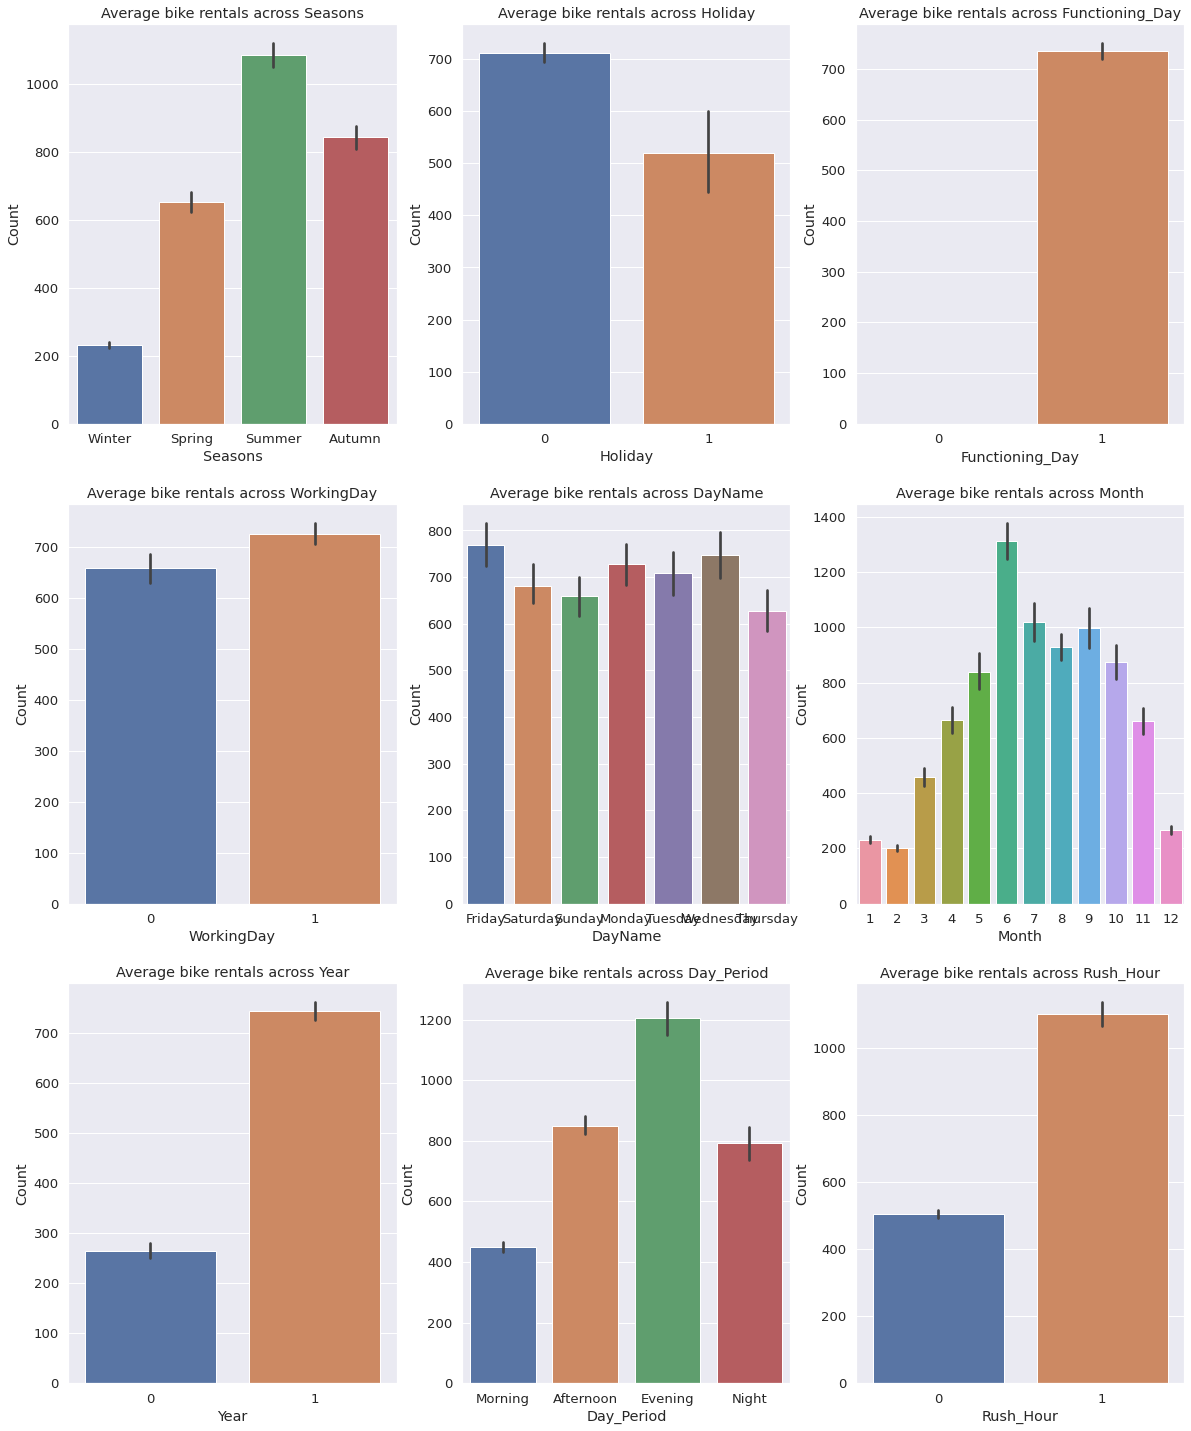

In [31]:
FeatureList=['Seasons', 'Holiday', 'Functioning_Day', 'WorkingDay','DayName',
                 'Month','Year','Day_Period', 'Rush_Hour']
def BarPlot(df,FeatureList):
    fig = plt.figure(figsize=(20, 25))
    i=1
    for feature in FeatureList:
        axes = fig.add_subplot(3, 3, i)
        sns.barplot(data=df, x=feature, y='y', ax=axes)
        axes.set(xlabel=feature, ylabel='Count', title='Average bike rentals across '+feature)
        i+=1

BarPlot(dfTrainNEW,FeatureList)

## Case2

<AxesSubplot:xlabel='Day', ylabel='y'>

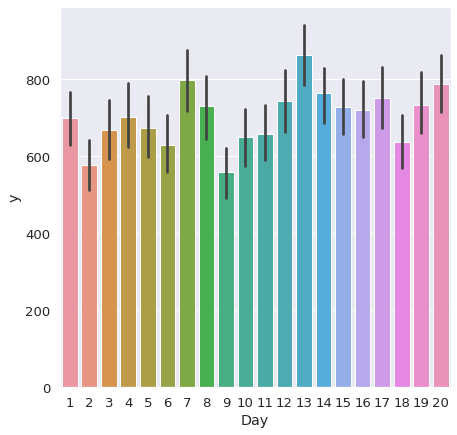

In [32]:
sns.barplot(data=dfTrainNEW, x='Day', y='y')

## Case3

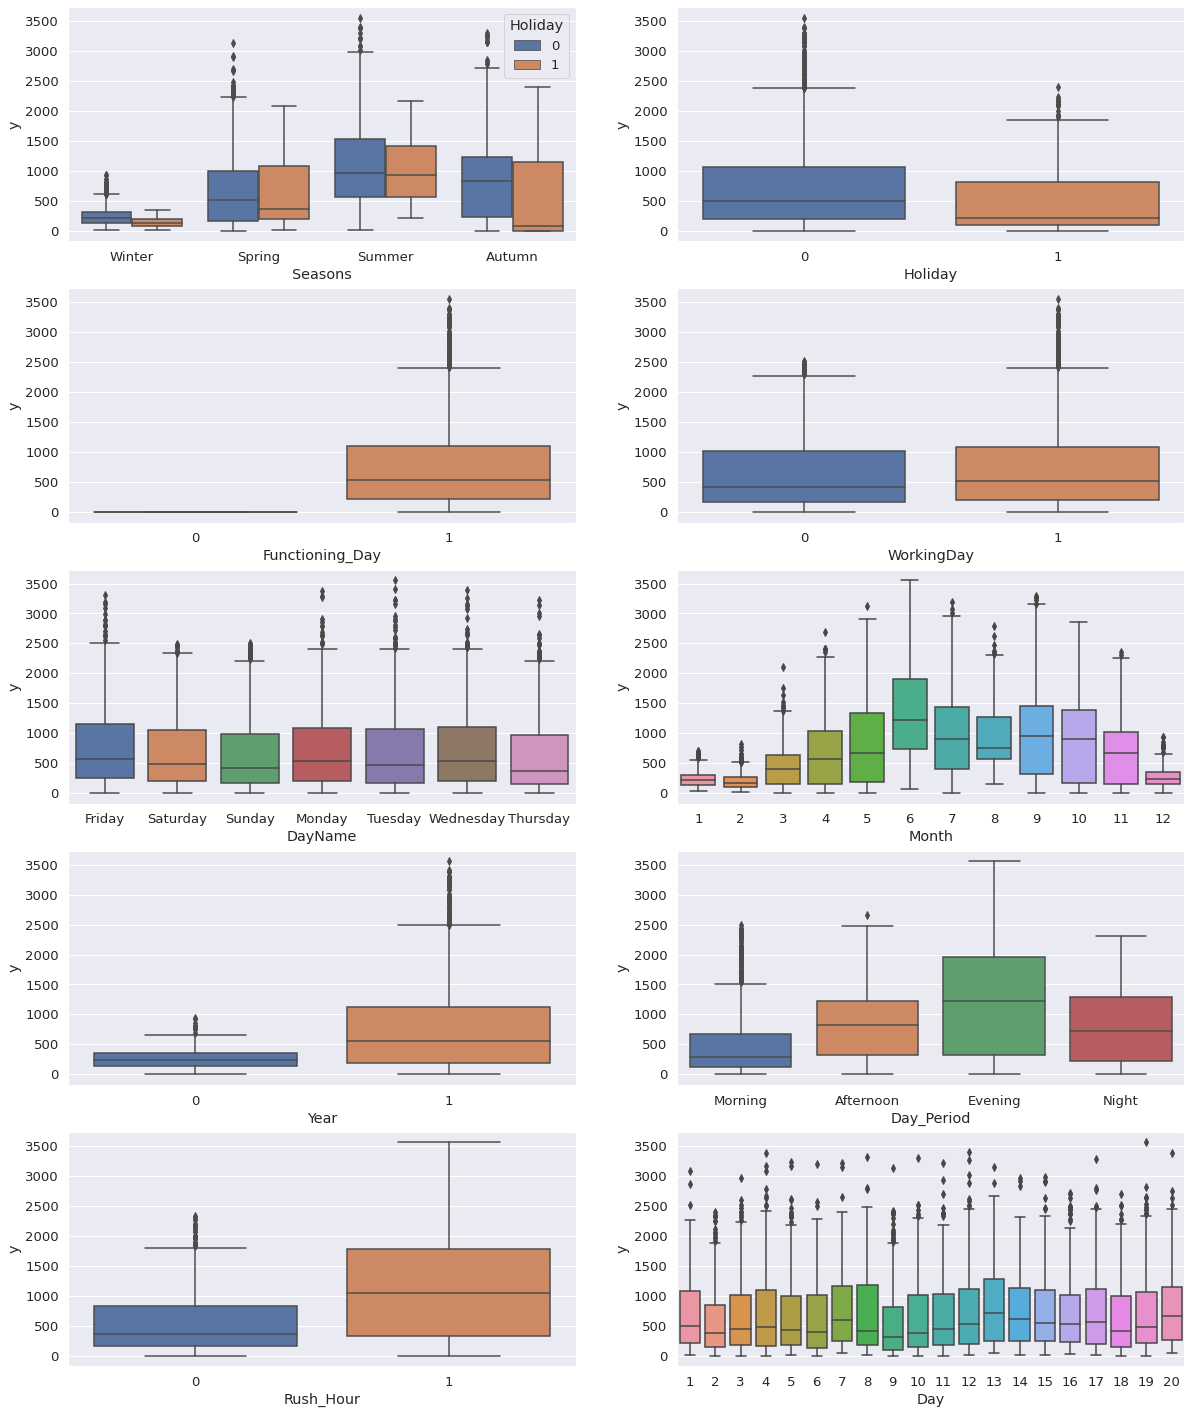

In [33]:
f, axes = plt.subplots(5, 2, figsize=(20, 25))

sns.boxplot(data=dfTrainNEW, y='y', x='Seasons'        , ax=axes[0][0],hue='Holiday')
sns.boxplot(data=dfTrainNEW, y='y', x='Holiday'        , ax=axes[0][1])
sns.boxplot(data=dfTrainNEW, y='y', x='Functioning_Day', ax=axes[1][0])
sns.boxplot(data=dfTrainNEW, y='y', x='WorkingDay'     , ax=axes[1][1])
sns.boxplot(data=dfTrainNEW, y='y', x='DayName'        , ax=axes[2][0])
sns.boxplot(data=dfTrainNEW, y='y', x='Month'          , ax=axes[2][1])
sns.boxplot(data=dfTrainNEW, y='y', x='Year'           , ax=axes[3][0])
sns.boxplot(data=dfTrainNEW, y='y', x='Day_Period'     , ax=axes[3][1])
sns.boxplot(data=dfTrainNEW, y='y', x='Rush_Hour'      , ax=axes[4][0])
sns.boxplot(data=dfTrainNEW, y='y', x='Day'            , ax=axes[4][1])

plt.show()

## Case4

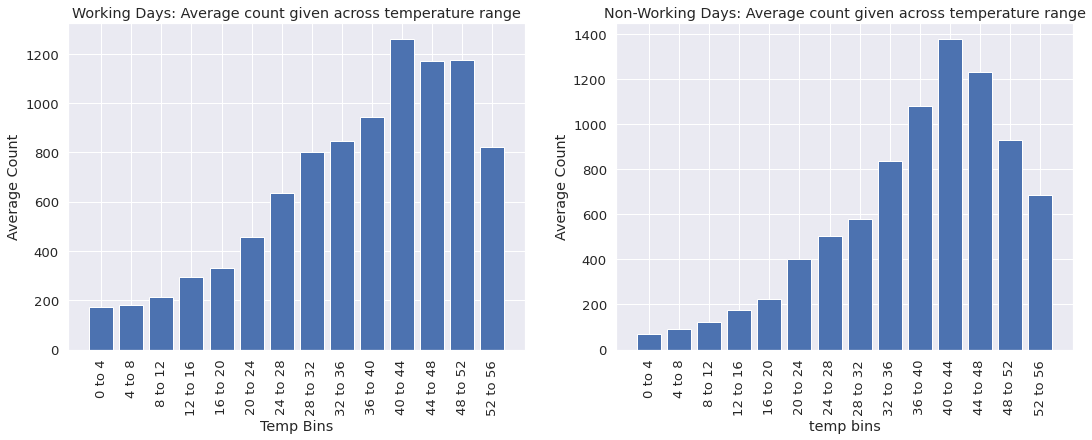

In [34]:
dfTrainNEW_w = dfTrainNEW[dfTrainNEW["WorkingDay"] == 1]
dfTrainNEW_nw = dfTrainNEW[dfTrainNEW["WorkingDay"] == 0]

bin_size = 4
dfTrainNEW_w['Temp Round'] = dfTrainNEW_w['Temperature']//bin_size
dfTrainNEW_nw['Temp Round'] = dfTrainNEW_nw['Temperature']//bin_size

mean_count_vs_temp_w = dfTrainNEW_w.groupby('Temp Round')['y'].mean()
mean_count_vs_temp_nw = dfTrainNEW_nw.groupby('Temp Round')['y'].mean()
idx_w, idx_nw = range(len(mean_count_vs_temp_w)), range(len(mean_count_vs_temp_nw))
labels_w = [str(bin_size*i)+' to '+str(bin_size*(i+1)) for i in range(len(mean_count_vs_temp_w))]
labels_nw = [str(bin_size*i)+' to '+str(bin_size*(i+1)) for i in range(len(mean_count_vs_temp_nw))]

fig = plt.figure(figsize=(18, 6))
axes = fig.add_subplot(1, 2, 1)
plt.bar(x=idx_w, height=mean_count_vs_temp_w)
plt.xticks(idx_w, labels_w, rotation=90)
plt.xlabel('Temp Bins')
plt.ylabel('Average Count')
plt.title('Working Days: Average count given across temperature range')

axes = fig.add_subplot(1, 2, 2)
plt.bar(x=idx_nw, height=mean_count_vs_temp_nw)
plt.xticks(idx_nw, labels_nw, rotation=90)
plt.xlabel('temp bins')
plt.ylabel('Average Count')
plt.title('Non-Working Days: Average count given across temperature range')

plt.show()

## Case5

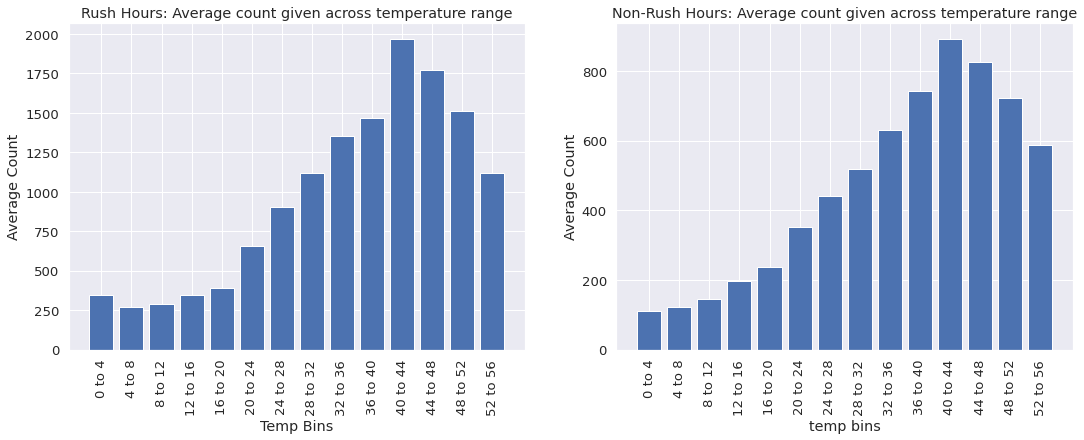

In [35]:
dfTrainNEW_R = dfTrainNEW[dfTrainNEW["Rush_Hour"] == 1]
dfTrainNEW_nR = dfTrainNEW[dfTrainNEW["Rush_Hour"] == 0]

bin_size = 4
dfTrainNEW_R['Temp Round'] = dfTrainNEW_R['Temperature']//bin_size
dfTrainNEW_nR['Temp Round'] = dfTrainNEW_nR['Temperature']//bin_size

mean_count_vs_temp_w = dfTrainNEW_R.groupby('Temp Round')['y'].mean()
mean_count_vs_temp_nw = dfTrainNEW_nR.groupby('Temp Round')['y'].mean()
idx_w, idx_nw = range(len(mean_count_vs_temp_w)), range(len(mean_count_vs_temp_nw))
labels_w = [str(bin_size*i)+' to '+str(bin_size*(i+1)) for i in range(len(mean_count_vs_temp_w))]
labels_nw = [str(bin_size*i)+' to '+str(bin_size*(i+1)) for i in range(len(mean_count_vs_temp_nw))]

fig = plt.figure(figsize=(18, 6))
axes = fig.add_subplot(1, 2, 1)
plt.bar(x=idx_w, height=mean_count_vs_temp_w)
plt.xticks(idx_w, labels_w, rotation=90)
plt.xlabel('Temp Bins')
plt.ylabel('Average Count')
plt.title('Rush Hours: Average count given across temperature range')

axes = fig.add_subplot(1, 2, 2)
plt.bar(x=idx_nw, height=mean_count_vs_temp_nw)
plt.xticks(idx_nw, labels_nw, rotation=90)
plt.xlabel('temp bins')
plt.ylabel('Average Count')
plt.title('Non-Rush Hours: Average count given across temperature range')

plt.show()

## Case6

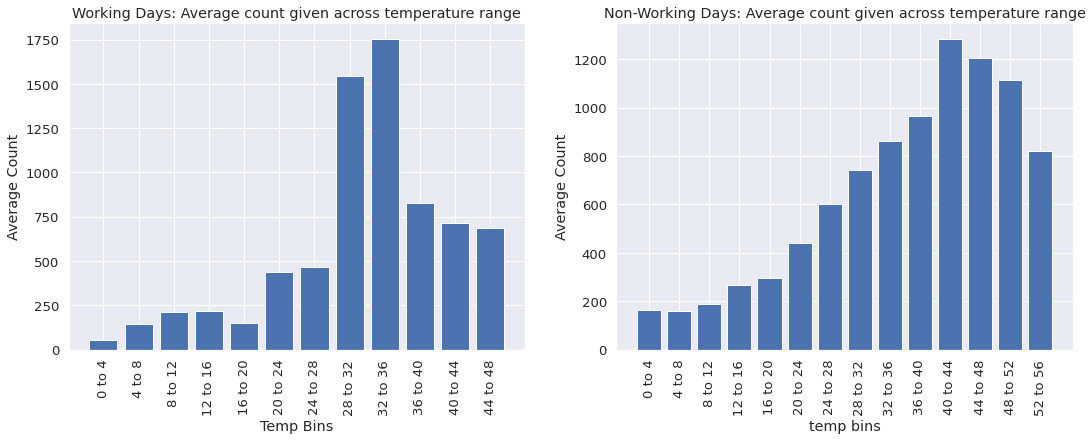

In [36]:
dfTrainNEW_w  = dfTrainNEW[dfTrainNEW["Holiday"] == 1]
dfTrainNEW_nw = dfTrainNEW[dfTrainNEW["Holiday"] == 0]

bin_size = 4
dfTrainNEW_w['Temp Round']  = dfTrainNEW_w['Temperature']//bin_size
dfTrainNEW_nw['Temp Round'] = dfTrainNEW_nw['Temperature']//bin_size

mean_count_vs_temp_w  = dfTrainNEW_w.groupby('Temp Round')['y'].mean()
mean_count_vs_temp_nw = dfTrainNEW_nw.groupby('Temp Round')['y'].mean()
idx_w, idx_nw = range(len(mean_count_vs_temp_w)), range(len(mean_count_vs_temp_nw))
labels_w = [str(bin_size*i)+' to '+str(bin_size*(i+1)) for i in range(len(mean_count_vs_temp_w))]
labels_nw = [str(bin_size*i)+' to '+str(bin_size*(i+1)) for i in range(len(mean_count_vs_temp_nw))]

fig  = plt.figure(figsize=(18, 6))
axes = fig.add_subplot(1, 2, 1)
plt.bar(x=idx_w, height=mean_count_vs_temp_w)
plt.xticks(idx_w, labels_w, rotation=90)
plt.xlabel('Temp Bins')
plt.ylabel('Average Count')
plt.title('Working Days: Average count given across temperature range')

axes = fig.add_subplot(1, 2, 2)
plt.bar(x=idx_nw, height=mean_count_vs_temp_nw)
plt.xticks(idx_nw, labels_nw, rotation=90)
plt.xlabel('temp bins')
plt.ylabel('Average Count')
plt.title('Non-Working Days: Average count given across temperature range')

plt.show()

## Case7

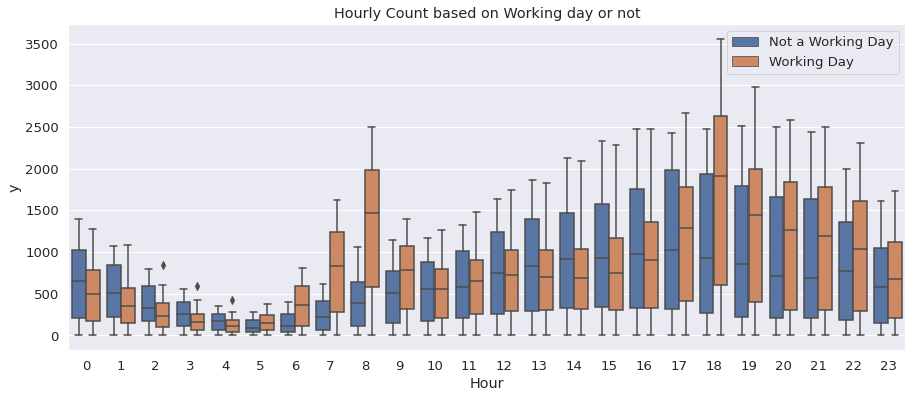

In [37]:
f, axes = plt.subplots(1, 1, figsize=(15, 6))
sns.boxplot(data=dfTrainNEW, y='y', x='Hour', hue='WorkingDay', ax=axes)
handles, _ = axes.get_legend_handles_labels()
axes.legend(handles, ['Not a Working Day', 'Working Day'])
axes.set(title='Hourly Count based on Working day or not')

plt.show()

## Case8

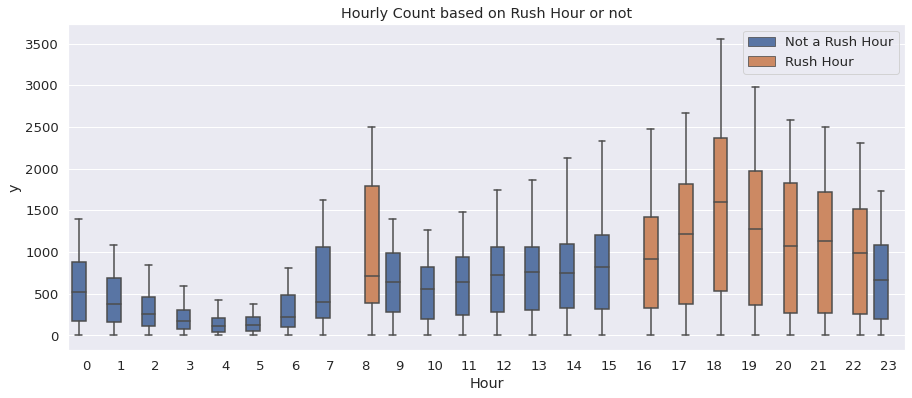

In [38]:
f, axes = plt.subplots(1, 1, figsize=(15, 6))
sns.boxplot(data=dfTrainNEW, y='y', x='Hour', hue='Rush_Hour', ax=axes)
handles, _ = axes.get_legend_handles_labels()
axes.legend(handles, ['Not a Rush Hour', 'Rush Hour'])
axes.set(title='Hourly Count based on Rush Hour or not')

plt.show()

## Case9

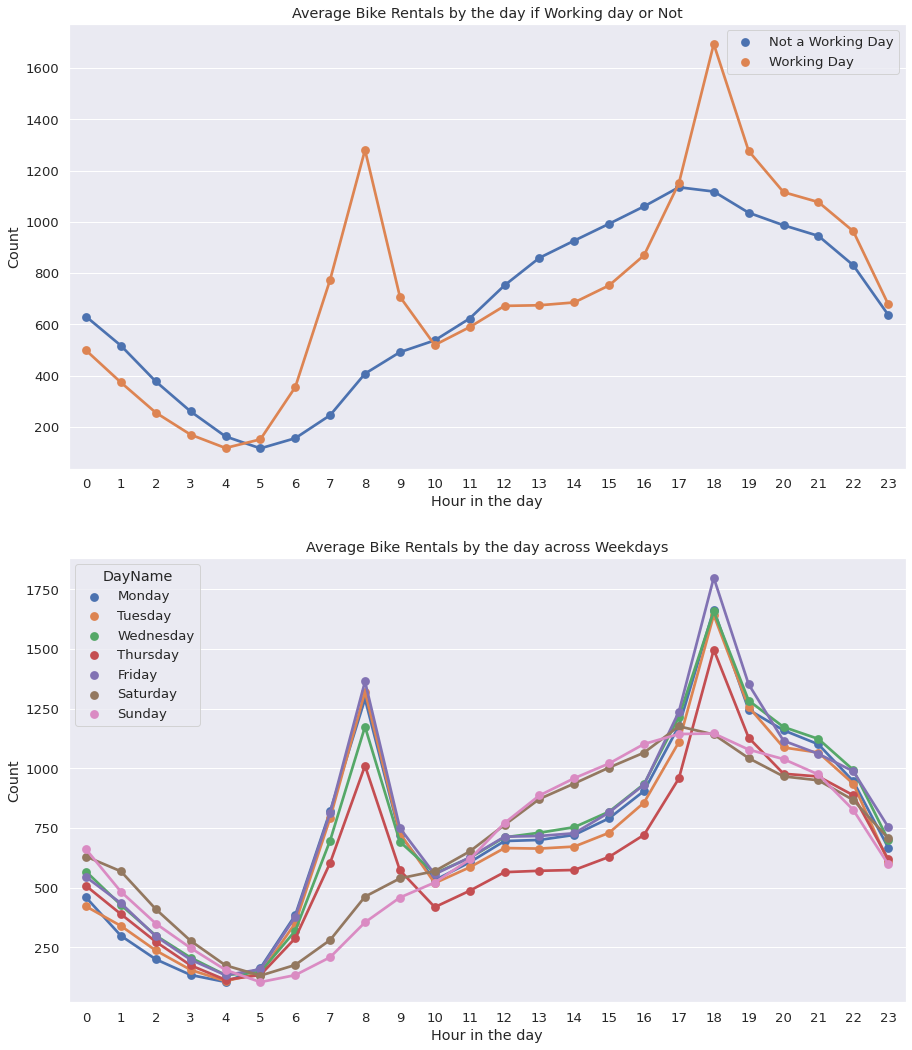

In [39]:
f, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 18))
group_work_hour = pd.DataFrame(dfTrainNEW.groupby(['WorkingDay', 'Hour'])['y'].mean()).reset_index()
sns.pointplot(data=group_work_hour, x='Hour', y='y', hue='WorkingDay', ax=axes[0], legend=True)
handles, _ = axes[0].get_legend_handles_labels()
axes[0].legend(handles, ['Not a Working Day', 'Working Day'])
axes[0].set(xlabel='Hour in the day', ylabel='Count', title='Average Bike Rentals by the day if Working day or Not')

hue_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
group_day_hour = pd.DataFrame(dfTrainNEW.groupby(['DayName', 'Hour'])['y'].mean()).reset_index()
sns.pointplot(data=group_day_hour, x='Hour', y='y', hue='DayName', ax=axes[1], hue_order=hue_order)
axes[1].set(xlabel='Hour in the day', ylabel='Count', title='Average Bike Rentals by the day across Weekdays')

plt.show()

## Case10

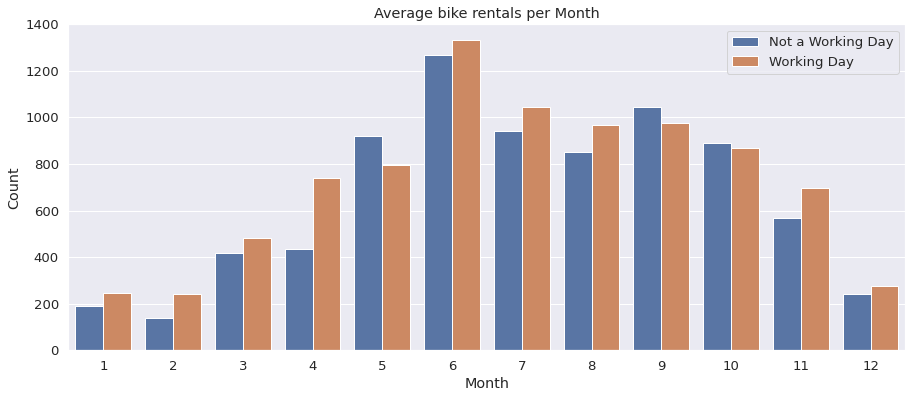

In [40]:
f, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
group_month = pd.DataFrame(dfTrainNEW.groupby(['Month', 'WorkingDay'])['y'].mean()).reset_index()
sns.barplot(data=group_month, x='Month', y='y', hue='WorkingDay', ax=axes)
axes.set(xlabel='Month', ylabel='Count', title='Average bike rentals per Month')
handles, _ = axes.get_legend_handles_labels()
axes.legend(handles, ['Not a Working Day', 'Working Day'])
plt.show()

_______________________________________________________

# Correlations

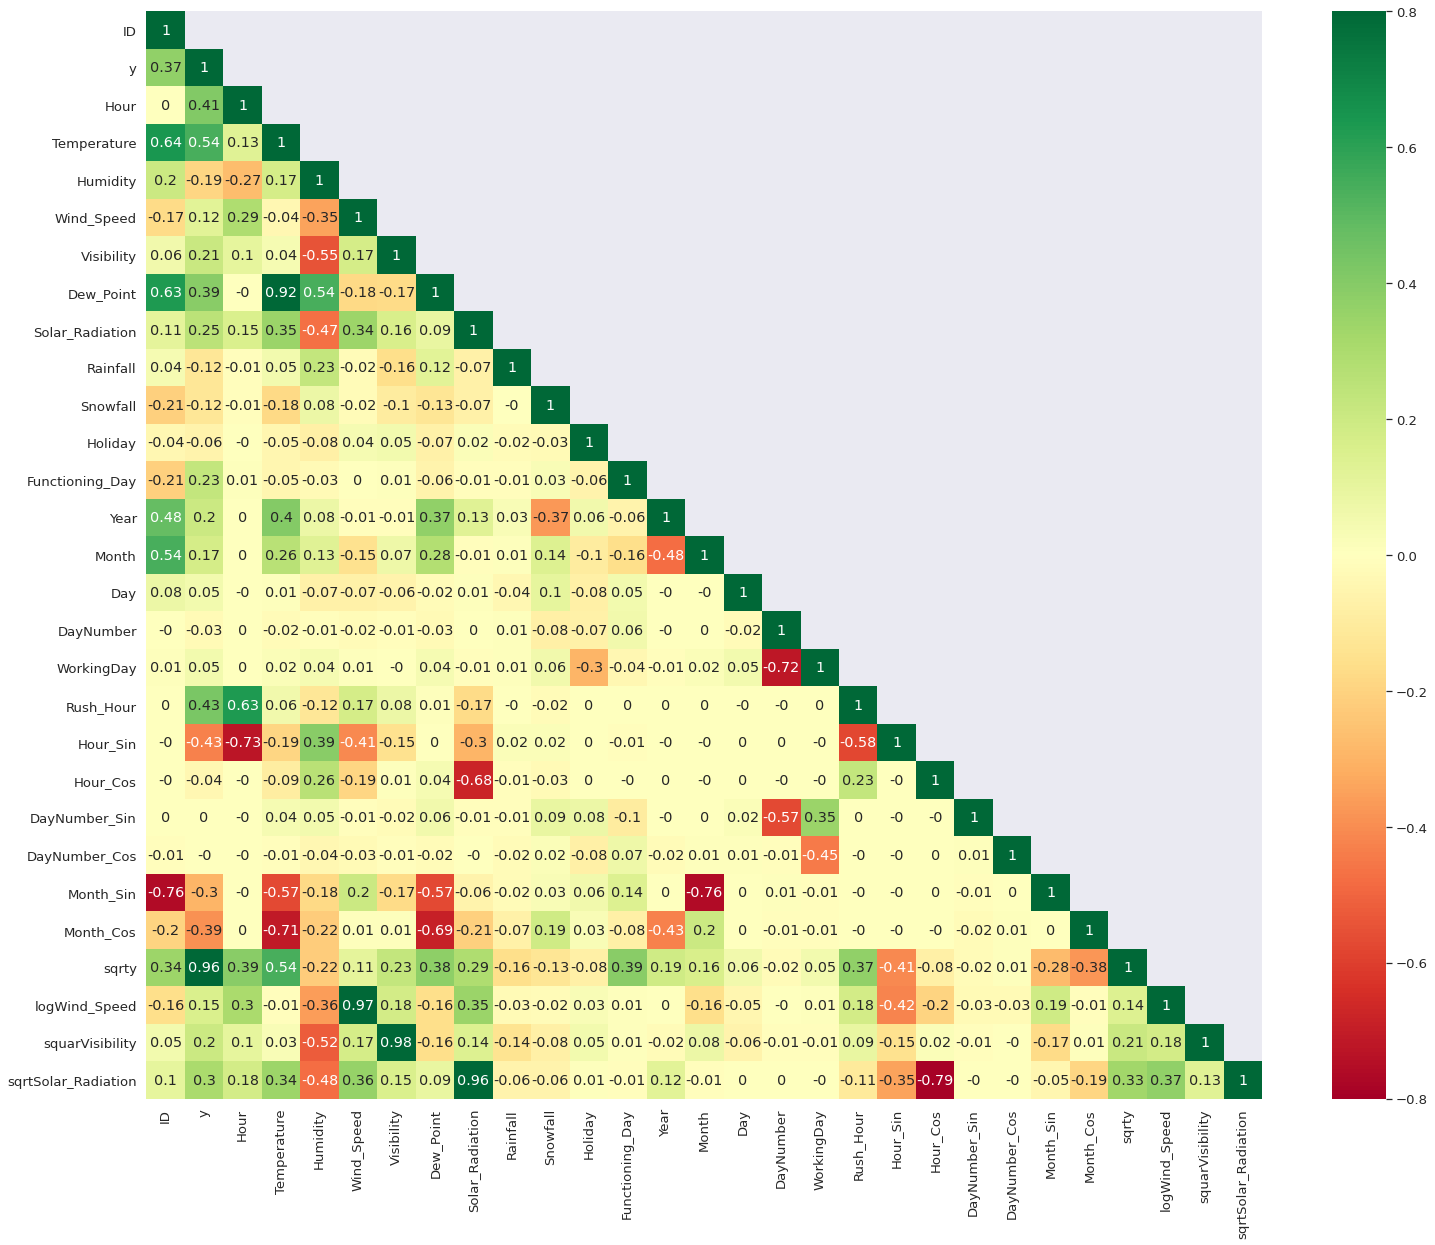

In [41]:
corr_matrix = dfTrainNEW.corr()
mask = np.array(corr_matrix)
mask[np.tril_indices_from(mask)] = False

fig = plt.figure(figsize=(25, 20))
sns.heatmap(np.round(corr_matrix,2), mask=mask, annot=True, cbar=True, vmax=0.8, vmin=-0.8, cmap='RdYlGn')
plt.show()

In [42]:
abs(dfTrainNEW.corr()["y"]).sort_values(ascending=False)

y                      1.000000
sqrty                  0.960573
Temperature            0.543863
Rush_Hour              0.429715
Hour_Sin               0.426541
Hour                   0.407180
Dew_Point              0.392454
Month_Cos              0.385054
ID                     0.365359
Month_Sin              0.297890
sqrtSolar_Radiation    0.297012
Solar_Radiation        0.250601
Functioning_Day        0.227269
Visibility             0.214777
squarVisibility        0.203074
Year                   0.201837
Humidity               0.191603
Month                  0.167181
logWind_Speed          0.150271
Snowfall               0.120836
Rainfall               0.117711
Wind_Speed             0.116380
Holiday                0.058329
WorkingDay             0.047454
Day                    0.045897
Hour_Cos               0.039578
DayNumber              0.025528
DayNumber_Cos          0.001677
DayNumber_Sin          0.000469
Name: y, dtype: float64

# Categorical Columns Encoding

## 1. One Hot Encoding

In [43]:
def OneHotEncoding(df,FeaturesL,Train_or_Test):
    if Train_or_Test == 'Train':
        dfTrainEncoded_Dummies = df.copy()
        dfTrainEncoded_Dummies = pd.get_dummies(dfTrainEncoded_Dummies,columns=FeaturesL,drop_first=True)
        return dfTrainEncoded_Dummies
    elif Train_or_Test == 'Test':
        dfTestEncoded_Dummies  = df.copy()
        dfTestEncoded_Dummies  = pd.get_dummies(dfTestEncoded_Dummies, columns=FeaturesL,drop_first=True)
        return dfTestEncoded_Dummies

_______________________________

## 2. Label Encoding

In [44]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

def LabelEncoding(df,FeaturesL,Train_or_Test):
    if Train_or_Test == 'Train':
        dfTrainEncoded_Labels = df.copy()
        dfTrainEncoded_Labels = MultiColumnLabelEncoder(columns=FeaturesL).fit_transform(dfTrainEncoded_Labels)
        return dfTrainEncoded_Labels
    elif Train_or_Test == 'Test':
        dfTestEncoded_Labels = df.copy()
        dfTestEncoded_Labels = MultiColumnLabelEncoder(columns=FeaturesL).fit_transform(dfTestEncoded_Labels)
        return dfTestEncoded_Labels

________________

# Check the Correlation

## 1. One Hot Encoding

In [45]:
FeaturesL=['DayName','Seasons','Day_Period']

In [46]:
dfTrainEncoded_Dummies=OneHotEncoding(dfTrainNEW,FeaturesL,'Train')

In [47]:
abs(dfTrainEncoded_Dummies.corr()["y"]).sort_values(ascending=False)

y                      1.000000
sqrty                  0.960573
Temperature            0.543863
Rush_Hour              0.429715
Hour_Sin               0.426541
Seasons_Winter         0.415673
Hour                   0.407180
Dew_Point              0.392454
Day_Period_Morning     0.389117
Month_Cos              0.385054
ID                     0.365359
Day_Period_Evening     0.341755
Seasons_Summer         0.336811
Month_Sin              0.297890
sqrtSolar_Radiation    0.297012
Solar_Radiation        0.250601
Functioning_Day        0.227269
Visibility             0.214777
squarVisibility        0.203074
Year                   0.201837
Humidity               0.191603
Month                  0.167181
logWind_Speed          0.150271
Snowfall               0.120836
Rainfall               0.117711
Wind_Speed             0.116380
Holiday                0.058329
WorkingDay             0.047454
DayName_Thursday       0.047000
Day                    0.045897
Seasons_Spring         0.044513
Day_Peri

In [48]:
abs(dfTrainEncoded_Dummies.corr()["y"]).sort_values().index

Index(['DayNumber_Sin', 'DayNumber_Cos', 'DayName_Tuesday', 'DayName_Saturday',
       'DayName_Monday', 'DayNumber', 'DayName_Wednesday', 'DayName_Sunday',
       'Hour_Cos', 'Day_Period_Night', 'Seasons_Spring', 'Day',
       'DayName_Thursday', 'WorkingDay', 'Holiday', 'Wind_Speed', 'Rainfall',
       'Snowfall', 'logWind_Speed', 'Month', 'Humidity', 'Year',
       'squarVisibility', 'Visibility', 'Functioning_Day', 'Solar_Radiation',
       'sqrtSolar_Radiation', 'Month_Sin', 'Seasons_Summer',
       'Day_Period_Evening', 'ID', 'Month_Cos', 'Day_Period_Morning',
       'Dew_Point', 'Hour', 'Seasons_Winter', 'Hour_Sin', 'Rush_Hour',
       'Temperature', 'sqrty', 'y'],
      dtype='object')

In [49]:
dfTrainEncoded_Dummies.columns

Index(['ID', 'Date', 'y', 'Hour', 'Temperature', 'Humidity', 'Wind_Speed',
       'Visibility', 'Dew_Point', 'Solar_Radiation', 'Rainfall', 'Snowfall',
       'Holiday', 'Functioning_Day', 'Year', 'Month', 'Day', 'DayNumber',
       'WorkingDay', 'Rush_Hour', 'Hour_Sin', 'Hour_Cos', 'DayNumber_Sin',
       'DayNumber_Cos', 'Month_Sin', 'Month_Cos', 'sqrty', 'logWind_Speed',
       'squarVisibility', 'sqrtSolar_Radiation', 'DayName_Monday',
       'DayName_Saturday', 'DayName_Sunday', 'DayName_Thursday',
       'DayName_Tuesday', 'DayName_Wednesday', 'Seasons_Spring',
       'Seasons_Summer', 'Seasons_Winter', 'Day_Period_Evening',
       'Day_Period_Morning', 'Day_Period_Night'],
      dtype='object')

## 2. Label Encoding

In [50]:
FeaturesL=['DayName','Seasons','Day_Period']

In [51]:
dfTrainEncoded_Labels=LabelEncoding(dfTrainNEW,FeaturesL,'Train')

In [52]:
abs(dfTrainEncoded_Labels.corr()["y"]).sort_values(ascending=False)

y                      1.000000
sqrty                  0.960573
Temperature            0.543863
Rush_Hour              0.429715
Hour_Sin               0.426541
Hour                   0.407180
Dew_Point              0.392454
Month_Cos              0.385054
ID                     0.365359
Month_Sin              0.297890
sqrtSolar_Radiation    0.297012
Solar_Radiation        0.250601
Seasons                0.239315
Day_Period             0.238598
Functioning_Day        0.227269
Visibility             0.214777
squarVisibility        0.203074
Year                   0.201837
Humidity               0.191603
Month                  0.167181
logWind_Speed          0.150271
Snowfall               0.120836
Rainfall               0.117711
Wind_Speed             0.116380
Holiday                0.058329
WorkingDay             0.047454
Day                    0.045897
Hour_Cos               0.039578
DayNumber              0.025528
DayName                0.018486
DayNumber_Cos          0.001677
DayNumbe

In [53]:
abs(dfTrainEncoded_Labels.corr()["y"]).sort_values().index

Index(['DayNumber_Sin', 'DayNumber_Cos', 'DayName', 'DayNumber', 'Hour_Cos',
       'Day', 'WorkingDay', 'Holiday', 'Wind_Speed', 'Rainfall', 'Snowfall',
       'logWind_Speed', 'Month', 'Humidity', 'Year', 'squarVisibility',
       'Visibility', 'Functioning_Day', 'Day_Period', 'Seasons',
       'Solar_Radiation', 'sqrtSolar_Radiation', 'Month_Sin', 'ID',
       'Month_Cos', 'Dew_Point', 'Hour', 'Hour_Sin', 'Rush_Hour',
       'Temperature', 'sqrty', 'y'],
      dtype='object')

____________________________________________

# Machine Learning Model 

## Train Data

In [54]:
FeaturesL=['DayName','Seasons','Day_Period']

In [55]:
dfTrainEncoded_Dummies=OneHotEncoding(dfTrainNEW, FeaturesL,'Train')
dfTestEncoded_Dummies =OneHotEncoding(dfTestNEW,  FeaturesL,'Test')

In [56]:
dfTrainEncoded_Labels=LabelEncoding(dfTrainNEW, FeaturesL,'Train')
dfTestEncoded_Labels =LabelEncoding(dfTestNEW,  FeaturesL,'Test')

In [57]:
dfTrain = dfTrainEncoded_Dummies[['ID','y','DayNumber_Sin', 'DayNumber_Cos', 'Day_Period_Morning','Day', 
                                  'Month_Cos', 'Solar_Radiation','DayNumber', 'Month', 
                                  'Rush_Hour', 'Month_Sin', 'WorkingDay','Hour_Cos', 
                                  'Seasons_Winter', 'Hour_Sin', 'Rainfall', 'Hour',
                                  'Humidity','Temperature', 'Functioning_Day']]

In [58]:
dfTest  = dfTestEncoded_Dummies[['ID','DayNumber_Sin', 'DayNumber_Cos', 'Day_Period_Morning','Day', 
                                 'Month_Cos', 'Solar_Radiation','DayNumber', 'Month', 
                                 'Rush_Hour', 'Month_Sin', 'WorkingDay','Hour_Cos', 
                                 'Seasons_Winter', 'Hour_Sin', 'Rainfall', 'Hour',
                                 'Humidity','Temperature', 'Functioning_Day']]

In [59]:
# train_df= dfTrain[~dfTrain['Day'].isin([16,17,18,19,20])]
# val_df  = dfTrain[dfTrain['Day'].isin([16,17,18,19,20])]

# X_train = train_df.drop(columns=["ID","y"])
# y_train = train_df['y']

# X_val   = val_df.drop(columns=["ID","y"])
# y_val   = val_df['y']

In [60]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(dfTrain, test_size=0.1, random_state=123,stratify =None)
X_train = train_df.drop(columns=["ID","y"])
y_train = train_df['y']
################################################################################################
X_val = val_df.drop(columns=["ID","y"])
y_val = val_df['y']

In [61]:
y_trainLog=np.log1p(y_train)
y_valLog=np.log1p(y_val)

In [62]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

# X_train=normalize(X_train)
# X_val=normalize(X_val)
# dfTest=normalize(dfTest)

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_val = scaler.transform(X_val)

# from sklearn.preprocessing import minmax_scale
# X_train = minmax_scale(X_train, feature_range=(0, 1))
# X_val = minmax_scale(X_val, feature_range=(0, 1))

# from sklearn.preprocessing import RobustScaler
# rb = RobustScaler()
# X_train= rb.fit_transform(X_train)
# X_val = rb.fit_transform(X_val)

# from sklearn.preprocessing import StandardScaler
# scaler  = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_val = scaler.transform(X_val)

In [63]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import BaggingRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

In [64]:
def rmsle(y_true, y_pred, convertExp=True):
    # Apply exponential transformation function
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
        
    # Convert missing value to zero after log transformation
    log_true = np.nan_to_num(np.array([np.log(y+1) for y in y_true]))
    log_pred = np.nan_to_num(np.array([np.log(y+1) for y in y_pred]))
    
    # Compute RMSLE
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

In [65]:
models = {
    "LinearRegression":            LinearRegression(),
    "Ridge":                       Ridge(),
    "Lasso":                       Lasso(),
    "ElasticNet":                  ElasticNet(),
    "KNeighborsRegressor":         KNeighborsRegressor(), 
    "DecisionTreeRegressor":       DecisionTreeRegressor(),
    "RandomForestRegressor":       RandomForestRegressor(),
    "BaggingRegressor":            BaggingRegressor(),
    "AdaBoostRegressor":           AdaBoostRegressor(),
    "CatBoostRegressor":           CatBoostRegressor(verbose=False),
    "LGBMRegressor":               LGBMRegressor(),
    "GradientBoostingRegressor":   GradientBoostingRegressor(),
    "XGBRegressor":                XGBRegressor()
}

In [66]:
for name, model in models.items():
    print(f'Using model: {name}')
    model.fit(X_train, y_trainLog)
    print(f"train score : {model.score(X_train,y_trainLog)}")
    print(f'RMSLETrain: {rmsle(y_trainLog, model.predict(X_train))}')
    print(f'RMSLEVal: {rmsle(y_valLog, model.predict(X_val))}')
    print('-'*30)

Using model: LinearRegression
train score : 0.826173473731749
RMSLETrain: 0.6726444115459816
RMSLEVal: 0.67232795315602
------------------------------
Using model: Ridge
train score : 0.8261583344718396
RMSLETrain: 0.6728261284689372
RMSLEVal: 0.6724654200139348
------------------------------
Using model: Lasso
train score : 0.20753350353744304
RMSLETrain: 1.3691792018113649
RMSLEVal: 1.4289644297521982
------------------------------
Using model: ElasticNet
train score : 0.21433791974664673
RMSLETrain: 1.3622333027387714
RMSLEVal: 1.4254280080858484
------------------------------
Using model: KNeighborsRegressor
train score : 0.6861565245602199
RMSLETrain: 0.8593722537193831
RMSLEVal: 1.0701694918691003
------------------------------
Using model: DecisionTreeRegressor
train score : 1.0
RMSLETrain: 2.136625207092849e-17
RMSLEVal: 0.4006659708795646
------------------------------
Using model: RandomForestRegressor
train score : 0.9946046902303947
RMSLETrain: 0.1206189913286941
RMSLEVal: 

## Test Data

RMSLETrain: 0.27904436647242126
RMSLEVal: 0.3238583318392887


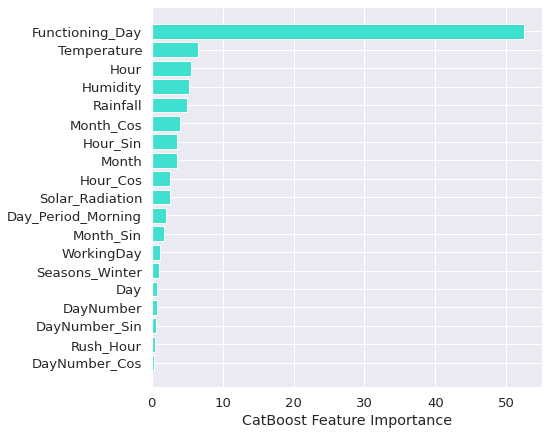

In [67]:
ID=dfTest["ID"]
X_test = dfTest.drop(columns=['ID'])

# Train the Model
Model=CatBoostRegressor(verbose=False,loss_function='MAE',n_estimators=1100,
                        learning_rate=0.08842105263157894 ,depth=4,l2_leaf_reg=2,random_strength=700)
Model.fit(X_train, y_trainLog)

# Print RMSLE for Train and Validation
print(f'RMSLETrain: {rmsle(y_trainLog, Model.predict(X_train))}')
print(f'RMSLEVal: {rmsle(y_valLog, Model.predict(X_val))}')

# Print the Features Importance of Cat Boost
sorted_feature_importance = Model.feature_importances_.argsort()
plt.barh(dfTest.drop(columns=['ID']).columns[sorted_feature_importance], 
        Model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")


dfTest.drop(columns=['ID']).columns[sorted_feature_importance]

# Predict the Bikes Count for Test Data
y_test_predicted = Model.predict(X_test)

dfTest['y'] =np.floor(np.exp(y_test_predicted)).astype('int')

dfTest['y'] = np.where(dfTest['Functioning_Day']==0, 0, dfTest['y'])
yPredictTest=dfTest['y']


dfTest.drop(columns="ID",inplace=True)
dfTest=pd.concat([dfTest, ID],axis=1)
dfTest.head()

dfTest[['ID', 'y']].to_csv('/kaggle/working/submission.csv', index=False)
# dfTest[['ID', 'y']].to_csv('submission.csv', index=False)


__________________________________________________